In [10]:
import sys
import math as math
import numpy as np

In [11]:
def rectangular_grid_to_coordinates( rows, columns, pitch ):
    
    num_points = columns * rows
    
    x_coords = np.linspace(-pitch * (columns - 1) / 2, 
                            pitch * (columns - 1) / 2, 
                            columns )
     
    y_coords = np.linspace(-pitch * (rows - 1) / 2, 
                            pitch * (rows - 1) / 2, 
                            rows )
    
    return np.array([ (x, y, 0.0) for x in x_coords for y in y_coords])

In [12]:
def hexagon_diameter_to_coordinates( d, x_spacing=10.5/1000, y_spacing=9/1000 ) -> list((float, float, float)): 
    """
    Coordinate system for d-transducers diameter hexagon. Centrepoint of central transducer is at origin (0,0,0).
    Array begins with the bottom left transducer.
    
    args: 
        d:          diameter of hexagon (longest row) in transducer units 
        x_spacing:  interspacing between elements in the x axis
        y_spacing:  interspacing between elements in the y axis
        f_tran:     focal length of the PAT [m]
    
    returns:
        coords: nx3 array of coords for this hexagon, with [0, 0, 0] as the centrepoint.
    """
    
    # from the diameter in transducer units (central and longest row) calculate array with transducers count 
    # for bottom row up to central row:    
    bottom_to_central_row_tran_count = np.arange(np.floor((d+1)/2), np.floor(d+1), 1, dtype=int)

    # calculate array with rows' transducers count:
    rows_transducer_count = np.concatenate( (   bottom_to_central_row_tran_count,
                                                np.flip( bottom_to_central_row_tran_count )[1:]), 
                                            axis=0)
    coords = []   
    # for each row, depending on whether it is offset or not (i.e. shifted in relation to central row), 
    # calculate and assign X Y coordinates to each transducer:
    for row, row_length in enumerate(rows_transducer_count):
        for elem in range(row_length):      
            coord_x = x_spacing * ( elem - row_length/2 + .5 )
            coord_y = -sys.maxsize - 1
            coord_z = 0
            
            if d % 2 != 0:
                coord_y = y_spacing * (row - (d-1)/2)
            else:
                coord_y = y_spacing * (row - d/2)
                
            coords.append((coord_x, coord_y, coord_z))  
    
    return np.array(coords)

In [13]:
# reference sound pressure level for airborne sound is 20 micropascals (μPa or e-6) or 15.849 μPa
db_spl_to_pascal = lambda db: 10**((db-20)/20e-6)

pascal_to_db_spl = lambda pa: 20*math.log10(pa/20e-6)

In [14]:

rho_a = 1.184                           # density of air at 25°C (kg/m3) 
c = 346.13                              # speed of sound in air at 25°C (m/s)
f = 40000                               # frequency (Hz)

_lambda = lambda f: c/f                 # wavelength (m)

_k = lambda f: 2 * math.pi/_lambda(f)   # wavenumber (cycles/m)

# Euclidean distance, 2-norm or magnitude of the vector, sqrt of the inner product of a vector with itself 
_distance = lambda pz, pt: math.sqrt( (pz[0]-pt[0])**2 + (pz[1]-pt[1])**2 + (pz[2]-pt[2])**2 )  

# cross product of pz and pt over the distance between pz
_sin_theta = lambda pz, pt: math.sqrt( (pz[0]-pt[0])**2 + (pz[1]-pt[1])**2 ) / _distance(pz, pt)  

def directivity(sin_theta, k, r=4.5/1000):

    # argument of 1st order Bessel function
    bessel_J1 = k*r*sin_theta
    
    # taylor expansion of first order Bessel function over its agrument — J_1(bessel_J1)/bessel_J1
    # wolframalpha.com – Series[BesselJ[1,x]/x,{x,0,10}] 
    taylor_exp = (1/2)-(bessel_J1**2/16)+(bessel_J1**4/384)-(bessel_J1**6/18432)+(bessel_J1**8/1474560)-(bessel_J1**10/176947200)+(bessel_J1**12/29727129600) 
    
    return 2 * taylor_exp


def reference_pressure(A=0.17, V=20): 
    """
    A — emitter output efficiency (Pa/m*V) 
    V — excitation signal peak-to-peak amplitude (Vpp)  
    """
    return A * V    

def pressure(p_ref, distance, sin_theta, k, r ):
    return p_ref * 1/distance * directivity(sin_theta, k, r) * np.exp(1j*k*distance)

In [15]:
def create_focusing_phasemap(T, z, k, phase_z = 0):
    """
    Builds phased array phase distribution for emitters at T to create a focal point at z,
    given a wavenumber k and 

    args:
        T: spatial coordinates of emitters              [(x, y, z)]
        z: spatial coordinates of focal point           (x, y, z)
        k: wavenumber                                   (cycles/m)
        phase_z: with which waves sync at focal point   (rad)
        
    returns:
        phase distribution to calculate focal point, normalised [-pi, pi] (float, float)
    """
    
    # phases of the emitters computed by backpropagating from the phase at the focal point and
    # number of cycles for the given distance based on the wavenumber 
    phases = phase_z - np.array([ _distance(z, t) for t in T ]) * k 

    # normalise between 0 and 2π [rads]
    return np.remainder(phases, 2*np.pi) - np.pi


In [18]:
M = 16
N = 16
pitch = 0.0105 # distance between the emitters centroids (m)
r = 4.5/1000

z = (0, 0, 0.15) # focal point, (m)

T = rectangular_grid_to_coordinates(M, N, pitch)
# print(T)

pressures = [ abs( 
                pressure( 
                    reference_pressure(A=0.17, V=18), 
                        _distance(z, t), 
                        _sin_theta(z, t), 
                        _k(40000), 
                        r )
                ) for t in T ] 

print(f'Total pressure: { sum(pressures) } Pa – { pascal_to_db_spl(sum(pressures)) } dB SPL')
# print(*pressures, sep='\n')

phases = create_focusing_phasemap(T, z, _k(40000), phase_z=0)
# print(phases)

Total pressure: 3852.9229484553944 Pa – 165.69520656651196 dB SPL


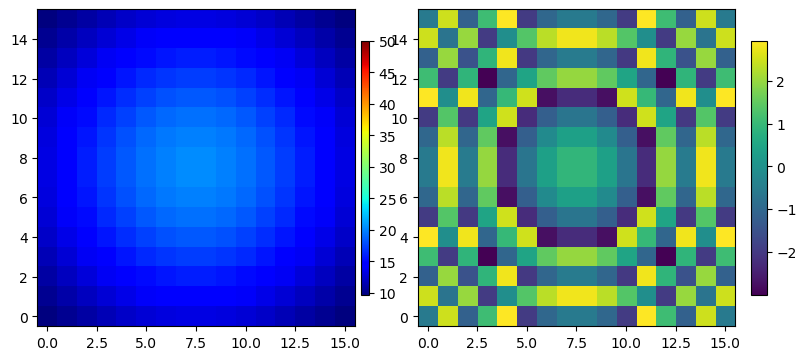

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 5))

# plot pressure at the focal point
im1 = ax1.imshow(np.array(pressures).reshape(16,16), plt.get_cmap("jet"), origin="lower", vmax=50)
cax = ax1.inset_axes([1.02, 0.1, 0.025, 0.8]) 
plt.colorbar(im1, cax=cax)

# plot phases of the transducers
im2 = ax2.imshow(np.array(phases).reshape(M,N), origin="lower")
cax = ax2.inset_axes([1.05, 0.1, 0.05, 0.8]) 
plt.colorbar(im2, cax=cax)